In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
import glob
import time
import subprocess
import os
import pickle
from scipy import stats

In [2]:
split_root = '/glade/work/jstarfeldt/autoencoder/autoencoder_train_split_files'
standard_root = '/glade/work/jstarfeldt/autoencoder/standard_arrays'
dataset_root = '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset'

In [3]:
np.random.seed(53)
torch.manual_seed(53)
random.seed(53)

## Data Visualization

In [4]:
dsL = xr.open_dataset(dataset_root+'/DMV/processed_Landsat/Landsat_Sentinel_image_DMV_202201081546.nc')
dsL

<xarray.Dataset> Size: 936MB
Dimensions:                    (y: 3000, x: 3000)
Coordinates:
  * x                          (x) float64 24kB 2.92e+05 2.92e+05 ... 3.82e+05
  * y                          (y) float64 24kB 4.282e+06 ... 4.372e+06
    datetime                   object 8B ...
Data variables: (12/14)
    Landsat_cloud_mask         (y, x) object 72MB ...
    Landsat_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance  (y, x) float64 72MB ...
    Landsat_red_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance  (y, x) float64 72MB ...
    ...                         ...
    Sentinel1_VV               (y, x) float64 72MB ...
    Sentinel1_VH               (y, x) float64 72MB ...
    Sentinel1_HH               (y, x) float64 72MB ...
    Sentinel1_HV               (y, x) float64 72MB ...
    Sentinel1_angle            (y, x) float64 72MB ...
    spatial_ref                int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Text(0.5, 1.0, 'Landsat LST, DMV 202201081546')

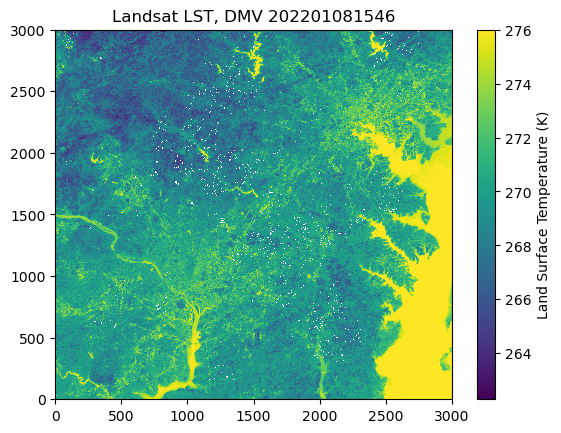

In [37]:
cb = plt.pcolormesh(dsL['Landsat_LST'], vmax=276)
plt.colorbar(cb, label='Land Surface Temperature (K)', orientation='vertical')
plt.title(f'Landsat LST, DMV 202201081546')

## Train Test Split

In [4]:
cities = [
    'DMV', 'NYC', 'Phoenix', 'Miami', 'Chicago', 'Denver', 'Seattle', 'San_Francisco', 'Los_Angeles', 'Atlanta', 'Toronto',
    'Mexico_City', 'Las_Vegas', 'Salt_Lake_City', 'Dallas', 'Houston', 'New_Orleans', 'St_Louis', 'Minneapolis', 'Jacksonville',
    'Charlotte', 'Philadelphia', 'San_Diego', 'San_Juan', 'Montreal', 'Guadalajara', 'Monterrey', 'Cancun', 'Billings', 'Guatemala_City',
    'San_Jose', 'Havana', 'Santo_Domingo', 'Tegucigalpa', 'Managua', 'Panama_City', 'Bogota', 'Lima', 'Quito', 'Santiago', 'Buenos_Aires',
    'Sao_Paulo', 'Manaus', 'Punta_Arenas', 'La_Paz', 'Montevideo', 'Brasilia', 'Caracas'
]
cities = sorted(cities)

In [5]:
def index_select(city):
    """
    Splits the Landsat files for a city into train and test files by index number.

    Args:
    city (str): The name of a city from the "cities" array

    Returns:
    train_indices (numpy array): Array of indices to be train files
    test_indices (numpy array): Array of indices to be test files
    """
    nFiles = len(os.listdir(dataset_root+f'/{city}/processed_Landsat')) # number of Landsat files for the city
    nums = np.arange(nFiles)
    train_indices = np.random.choice(nums, round(nFiles*0.6), replace=False)
    test_indices = np.setdiff1d(nums, train_indices)

    return [train_indices, test_indices]

In [6]:
train_test_indices = {string: index_select(string) for string in cities}
train_test_indices

{'Atlanta': [array([ 1, 19,  8,  7, 30, 34, 17,  4, 33,  2, 10, 15,  0, 27, 14, 32, 23,
         21, 13, 28,  6]),
  array([ 3,  5,  9, 11, 12, 16, 18, 20, 22, 24, 25, 26, 29, 31])],
 'Billings': [array([33, 18, 32,  4,  3, 27, 17, 30, 29, 24, 10,  6, 15, 31,  2, 16, 14,
         26, 19, 11]),
  array([ 0,  1,  5,  7,  8,  9, 12, 13, 20, 21, 22, 23, 25, 28])],
 'Bogota': [array([19, 26, 18,  3, 16, 32, 12, 35, 23, 37, 15, 27, 22,  9,  8, 28, 14,
         11, 38, 34,  0,  6, 33]),
  array([ 1,  2,  4,  5,  7, 10, 13, 17, 20, 21, 24, 25, 29, 30, 31, 36])],
 'Brasilia': [array([ 8, 23, 43, 34, 20, 38, 27, 41, 32, 14, 31,  7, 35, 24, 33, 36,  6,
         21, 16, 42, 10, 22, 19, 28, 17,  0]),
  array([ 1,  2,  3,  4,  5,  9, 11, 12, 13, 15, 18, 25, 26, 29, 30, 37, 39,
         40])],
 'Buenos_Aires': [array([ 1, 18,  0, 15,  5, 25, 16,  3, 27,  7, 29, 35, 22, 12,  8, 32, 30,
         23, 33, 14, 31, 17]),
  array([ 2,  4,  6,  9, 10, 11, 13, 19, 20, 21, 24, 26, 28, 34])],
 'Cancun': [array(

In [7]:
Landsat_dim = 3000
train_dim = 32
n_files_per_dim = int(np.floor(Landsat_dim/train_dim))
start_i = round((Landsat_dim-n_files_per_dim*train_dim)/2)
print(n_files_per_dim, start_i)

93 12


In [8]:
def split_func(city):
    """
    Splits the Landsat training images for a city from dimensions of 3000x3000 into
    smaller 32x32 images. And saves them as .npy files.

    Args:
    city (str): The name of a city from the "cities" array
    """
    train_indices = train_test_indices[city][0]
    train_file_list = np.array(sorted(glob.glob(dataset_root+f'/{city}/processed_Landsat/*')))[train_indices]
    existing_list = glob.glob(f'{split_root}/{city}/*')

    LST_arrays = []
    for file in train_file_list:
        arr = xr.open_dataset(file)['Landsat_LST'].values
        LST_arrays.append(arr)
    
    LST_arrays_comb = np.stack(LST_arrays)
    LST_mean = np.nanmean(LST_arrays_comb)
    LST_std = np.nanstd(LST_arrays_comb)

    standard_array = np.array([LST_mean, LST_std])
    np.save(f'{standard_root}/{city}_mean_std.npy', standard_array)

    subprocess.call(['mkdir', '-p', f'{split_root}/{city}'])

    for file in train_file_list:
        fname = file.split('/')[-1].split('.')[0]
        LST_arr = xr.load_dataset(file)['Landsat_LST'].values
    
        for i in range(n_files_per_dim):
            #print(i)
            row = i*32+start_i
            for j in range(n_files_per_dim):
                col = j*32+start_i
                #print(row, col)
                arr = LST_arr[row:row+32, col:col+32]
                if f'{split_root}/{city}/{fname}_{row}_{col}.npy' in existing_list:
                    continue
                else:
                    np.save(f'{split_root}/{city}/{fname}_{row}_{col}.npy', arr)

In [12]:
for city in cities[38:]:
    print(city)
    split_func(city)

San_Francisco
San_Jose
San_Juan
Santiago
Santo_Domingo
Sao_Paulo
Seattle
St_Louis
Tegucigalpa
Toronto


## Model stuff

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [8]:
os.system("taskset -c -p 0-95 %d" % os.getpid())

pid 131023's current affinity list: 39
pid 131023's new affinity list: 39


0

In [9]:
cpus_avail = len(os.sched_getaffinity(0))
cpus_avail

1

In [10]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, mean, std, transform=None, standardize=True):
        self.img_list = sorted(glob.glob(img_dir+'/*'))
        self.mean = mean
        self.std = std
        self.transform = transform
        self.standardize = standardize

        indices = np.arange(len(self.img_list))
        self.train_indices = np.random.choice(indices, round(len(indices)*0.8), replace=False)
        self.val_indices = np.setdiff1d(indices, self.train_indices)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        arr = np.load(self.img_list[idx], allow_pickle=True)
        #print(self.img_list[idx])
        
        if self.standardize:
            arr = (arr-self.mean)/self.std

        #arr = np.concat([cloud, arr])
        image = torch.from_numpy(arr)
        if self.transform:
            image = self.transform(image)
            
        return torch.unsqueeze(image.to(torch.float32), 0)

In [11]:
class HeatAutoencoder(nn.Module):
    def __init__(self):
        super(HeatAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv6 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        self.norm1 = nn.BatchNorm2d(num_features=16)
        self.norm2 = nn.BatchNorm2d(num_features=32)
        self.norm3 = nn.BatchNorm2d(num_features=64)
        self.norm4 = nn.BatchNorm2d(num_features=64)
        self.norm5 = nn.BatchNorm2d(num_features=32)
        self.norm6 = nn.BatchNorm2d(num_features=16)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        #self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x, indices2 = self.pool(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x, indices3 = self.pool(x)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.unpool(x, indices3)

        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = self.unpool(x, indices2)
            
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.relu(x)
        x = self.unpool(x, indices1)

        x = self.conv7(x)
        return x

In [12]:
loss_fn = nn.MSELoss()

def custom_loss(outputs, features, mask):
    outputs = outputs[mask == 1]
    features = features[mask == 1]

    return loss_fn(outputs, features)

In [13]:
def model_one_city(city, batch_size=128, epochs=20, lr=0.001, early_stopping_cushion=0):
    standard_arr = np.load(f'{standard_root}/{city}_mean_std.npy')
    LST_mean = standard_arr[0]
    LST_std = standard_arr[1]
    
    train_dataset = TrainDataset(f'{split_root}/{city}', LST_mean, LST_std)
    model = HeatAutoencoder()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #logging_interval = 1
    #skip_epoch_stats = False
    save_model = f'/glade/work/jstarfeldt/autoencoder/model_saves/{city}_autoencoder.pth'
    save_dict = f'/glade/work/jstarfeldt/autoencoder/dict_saves/{city}_loss_dict.pkl'

    log_dict = {'train_loss_per_batch': [],
                    'train_loss_per_epoch': [],
               'val_loss_per_fold': [],
               'val_loss_per_epoch': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        running_train_loss = 0
        running_val_loss = 0
        
        # Create subsets for training and validation
        train_subset = Subset(train_dataset, train_dataset.train_indices)
        val_subset = Subset(train_dataset, train_dataset.val_indices)
        # Create dataloaders for the respective subset
        train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=32)
        val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=32)
    
        # Model training
        model.train()
        for batch_idx, features in enumerate(train_dataloader):
            mask = torch.where(torch.isnan(features), 0, 1)
            features = torch.nan_to_num(features, nan=0)
            # FORWARD AND BACK PROP
            logits = model(features)
            loss = custom_loss(logits, features, mask)
            optimizer.zero_grad()
            loss.backward()
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            # LOGGING
            batch_loss = loss.item()
            #log_dict['train_loss_per_batch'].append(batch_loss)
            running_train_loss += batch_loss
            #if not fold % logging_interval:
            #    print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
            #          % (epoch+1, num_epochs, batch_idx+1,
            #              len(train_dataloader), batch_loss))
        train_loss = running_train_loss/(batch_idx+1)
        # Model validation
        with torch.no_grad():
            model.eval()
            for batch_idx, features in enumerate(val_dataloader):
                mask = torch.where(torch.isnan(features), 0, 1)
                features = torch.nan_to_num(features, nan=0)
                # FORWARD AND BACK PROP
                logits = model(features)
                loss = custom_loss(logits, features, mask)
                batch_loss = loss.item()
                #log_dict['val_loss_per_fold'].append(val_loss)
                running_val_loss += batch_loss
                #print('Val Loss: %.4f'
                #          % (val_loss))
        val_loss = running_val_loss/(batch_idx+1)
        
        print('Train Loss: %.4f | Val Loss: %.4f'  % (train_loss, val_loss))
    
        with torch.set_grad_enabled(False):  # save memory during inference
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, epochs, running_train_loss))
    
        torch.save(model.state_dict(), save_model) # Save model
        log_dict['train_loss_per_epoch'].append(train_loss) # Append losses
        log_dict['val_loss_per_epoch'].append(val_loss)
        with open(save_dict, 'wb') as file: # Save loss dictionary
            pickle.dump(log_dict, file)
            
        if epoch >= 2:
            if (log_dict['val_loss_per_epoch'][-2] > log_dict['val_loss_per_epoch'][-3] and
                log_dict['val_loss_per_epoch'][-1] > log_dict['val_loss_per_epoch'][-2] + early_stopping_cushion):
                print('Early stopping')
                break
            
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [13]:
cities[44]

'Seattle'

In [14]:
for city in cities[44:]:
    model_one_city(city)

Train Loss: 0.0538 | Val Loss: 0.0128
***Epoch: 001/020 | Loss: 66.913
Time elapsed: 2.25 min
Train Loss: 0.0109 | Val Loss: 0.0072
***Epoch: 002/020 | Loss: 13.589
Time elapsed: 4.51 min
Train Loss: 0.0067 | Val Loss: 0.0020
***Epoch: 003/020 | Loss: 8.273
Time elapsed: 6.77 min
Train Loss: 0.0056 | Val Loss: 0.0044
***Epoch: 004/020 | Loss: 6.936
Time elapsed: 9.05 min
Train Loss: 0.0052 | Val Loss: 0.0019
***Epoch: 005/020 | Loss: 6.433
Time elapsed: 11.32 min
Train Loss: 0.0046 | Val Loss: 0.0015
***Epoch: 006/020 | Loss: 5.670
Time elapsed: 13.59 min
Train Loss: 0.0048 | Val Loss: 0.0024
***Epoch: 007/020 | Loss: 5.925
Time elapsed: 15.87 min
Train Loss: 0.0042 | Val Loss: 0.0011
***Epoch: 008/020 | Loss: 5.245
Time elapsed: 18.13 min
Train Loss: 0.0040 | Val Loss: 0.0018
***Epoch: 009/020 | Loss: 5.008
Time elapsed: 20.40 min
Train Loss: 0.0038 | Val Loss: 0.0010
***Epoch: 010/020 | Loss: 4.742
Time elapsed: 22.66 min
Train Loss: 0.0036 | Val Loss: 0.0010
***Epoch: 011/020 | Loss

## Load model and testing

In [12]:
date_dict = {string: [] for string in cities}
date_str_dict = {string: [] for string in cities}

In [13]:
format_string = "%Y%m%d%H%M"

for city in cities:
    #print(city)
    city_list = sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*'))
    for file in city_list:
        #print(file)
        dt_str = file.split('_')[-1].split('.')[0]
        dt = datetime.datetime.strptime(dt_str, format_string)
        date_dict[city].append(dt)
        date_str_dict[city].append(dt_str[:8])

In [15]:
city = 'Las_Vegas'
save_model = f'/glade/work/jstarfeldt/autoencoder/model_saves/{city}_autoencoder.pth'
save_dict = f'/glade/work/jstarfeldt/autoencoder/dict_saves/{city}_loss_dict.pkl'
model = HeatAutoencoder()
model.load_state_dict(torch.load(save_model, weights_only=True))

<All keys matched successfully>

In [47]:
with open(save_dict, 'rb') as file:
    log_dict = pickle.load(file)

In [48]:
#train_files_per_epoch = len(log_dict['train_loss_per_batch'])/num_epochs
train_losses = np.array(log_dict['train_loss_per_epoch'])
train_losses

array([0.05790231, 0.01144625, 0.00720627, 0.00623188, 0.00545097,
       0.00523654, 0.00506171, 0.00479384, 0.00445612, 0.00440943,
       0.00406017, 0.00441954, 0.00382197])

In [49]:
#val_files_per_epoch = len(log_dict['val_loss_per_fold'])/num_epochs
val_losses = np.array(log_dict['val_loss_per_epoch'])
val_losses

array([0.01136969, 0.00432865, 0.00461162, 0.00268187, 0.00362377,
       0.0016225 , 0.0015076 , 0.00365017, 0.0012265 , 0.00687017,
       0.00194419, 0.002137  , 0.0024468 ])

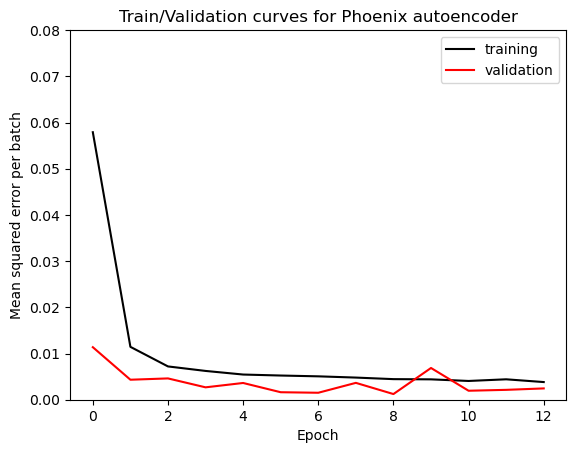

In [52]:
plt.plot(train_losses, c='k', label='training')
plt.plot(val_losses, c='r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error per batch')
plt.ylim(0, 0.08)
plt.title(f'Train/Validation curves for {city} autoencoder')
plt.legend()
plt.show()

In [14]:
class AnalysisDataset(Dataset):
    def __init__(self, img_dir, city, img_dimension=32, transform=None, standardize=True):
        test_indices = train_test_indices[city][1]
        standard_arr = np.load(f'{standard_root}/{city}_mean_std.npy')
        self.img_list = np.array(sorted(glob.glob(f'{img_dir}/*')))[test_indices]
        self.var_mean = standard_arr[0]
        self.var_std = standard_arr[1]
        self.img_dimension = img_dimension
        self.transform = transform
        self.standardize = standardize

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        ds = xr.open_dataset(self.img_list[idx])
        arr = ds['Landsat_LST'].values
        
        if self.standardize:
            arr = (arr-self.var_mean)/self.var_std

        image = torch.from_numpy(arr.astype(np.float32))
        if self.transform:
            image = self.transform(image)
            
        return image

In [16]:
analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)

In [15]:
def get_reconstructed_data(image, model, LST_mean, LST_std):
    image = torch.expand_copy(image, size=(1,1,3000,3000))

    mask = torch.where(torch.isnan(image), 0, 1)
    features = torch.nan_to_num(image, nan=0)
    # FORWARD AND BACK PROP
    logits = model(features)

    a = features*LST_std + LST_mean # Reconstructed features
    b = logits*LST_std + LST_mean # Reconstructed outputs

    return a, b.detach()

In [19]:
a, b = get_reconstructed_data(analysis_dataset[4], model, analysis_dataset.var_mean, analysis_dataset.var_std)

Text(0.5, 1.0, 'Original')

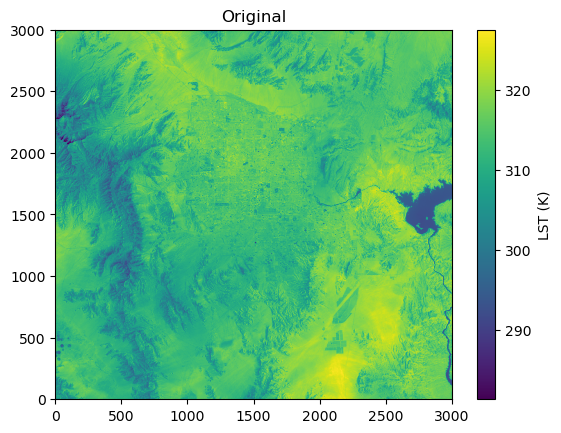

In [20]:
cb = plt.pcolormesh(a[0,0])
plt.colorbar(cb, label='LST (K)', orientation='vertical')
plt.title('Original')

Text(0.5, 1.0, 'Reconstructed')

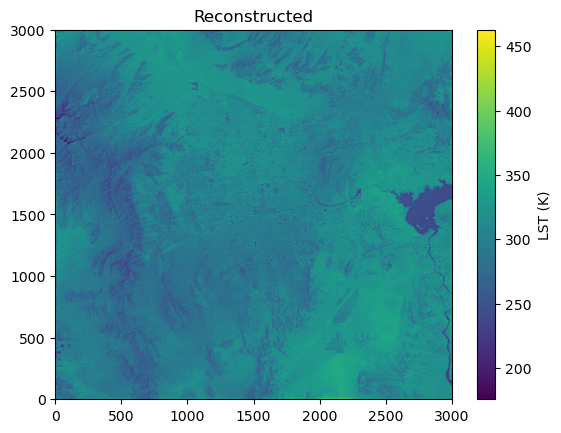

In [21]:
cb = plt.pcolormesh(b[0,0])#, vmin=torch.min(a[0,0]), vmax=torch.max(a[0,0]))
plt.colorbar(cb, label='LST (K)', orientation='vertical')
plt.title('Reconstructed')

Text(0.5, 1.0, 'Absolute LST Reconstruction Error')

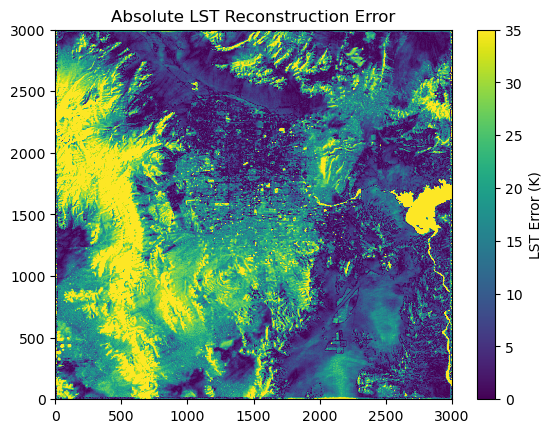

In [22]:
cb = plt.pcolormesh(torch.abs(a-b)[0,0], vmax=35)
plt.colorbar(cb, label='LST Error (K)', orientation='vertical')
plt.title('Absolute LST Reconstruction Error')

In [31]:
torch.mean(torch.abs(a-b)**2).item()

387.84808349609375

In [18]:
reconstruction_loss_dict = {string: [] for string in cities}

In [22]:
for city in cities[-1:]:
    save_model = f'/glade/work/jstarfeldt/autoencoder/model_saves/{city}_autoencoder.pth'
    model = HeatAutoencoder()
    model.load_state_dict(torch.load(save_model, weights_only=True))
    analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)
    for file in analysis_dataset:
        a, b = get_reconstructed_data(file)
        reconstruction_loss_dict[city].append(torch.mean(torch.abs(a-b)**2).item())

In [23]:
with open('/glade/work/jstarfeldt/autoencoder/reconstruction_dict.pkl', 'wb') as file:
    pickle.dump(reconstruction_loss_dict, file)

In [16]:
with open('/glade/work/jstarfeldt/autoencoder/reconstruction_dict.pkl', 'rb') as file:
    reconstruction_loss_dict = pickle.load(file)

In [28]:
city = 'Atlanta'
analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)

In [29]:
analysis_dataset.img_list

array(['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202203251612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202205121612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202207311612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202209011612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202209171613.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202211201612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202301231612.nc',
       '/glade/derecho/scratch/jstarfeldt/urban_

In [17]:
import matplotlib.ticker as mticker

In [18]:
def get_pdf(data):
    """
    Constructs a gaussian pdf from an array of data.

    Args:
    data (array-like): Array of data to construct a pdf from

    Returns:
    x (numpy array): Array of x-values for the pdf of same length as the pdf array
    pdf (numpy array): Array of frequency values for the pdf of the same length as the x array
    """
    mean = np.nanmean(data)
    std_dev = np.nanstd(data)
    x = np.linspace(np.nanmin(data)-8, np.nanmax(data)+8, 1000)
    #x = np.linspace(150, 337, 1000)
    pdf = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
    return x, pdf

In [19]:
def get_reconstruction_error_seasons(analysis_dataset):
    DJF_errors = []
    MAM_errors = []
    JJA_errors = []
    SON_errors = []
    
    for i in range(len(analysis_dataset)):
        dt_str = analysis_dataset.img_list[i].split('_')[-1].split('.')[0]
        month = dt_str[4:6]
        if month in ['12', '01', '02']:
            DJF_errors.append(reconstruction_loss_dict[city][i])
        elif month in ['03', '04', '05']:
            MAM_errors.append(reconstruction_loss_dict[city][i])
        elif month in ['06', '07', '08']:
            JJA_errors.append(reconstruction_loss_dict[city][i])
        else:
            SON_errors.append(reconstruction_loss_dict[city][i])

    return DJF_errors, MAM_errors, JJA_errors, SON_errors

In [22]:
get_reconstruction_error_seasons(analysis_dataset)

([165.44654846191406, 137.68922424316406, 193.40850830078125],
 [151.8096923828125],
 [2091.175048828125,
  909.1586303710938,
  169.86402893066406,
  996.6957397460938,
  870.2205200195312],
 [871.935546875, 103.71741485595703])

In [24]:
all_DJF_errors = []
all_MAM_errors = []
all_JJA_errors = []
all_SON_errors = []

for city in cities:
    analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)
    DJF_errors, MAM_errors, JJA_errors, SON_errors = get_reconstruction_error_seasons(analysis_dataset)
    all_DJF_errors.append(DJF_errors)
    all_MAM_errors.append(MAM_errors)
    all_JJA_errors.append(JJA_errors)
    all_SON_errors.append(SON_errors)

all_DJF_errors = np.concatenate(all_DJF_errors)
all_MAM_errors = np.concatenate(all_MAM_errors)
all_JJA_errors = np.concatenate(all_JJA_errors)
all_SON_errors = np.concatenate(all_SON_errors)

In [30]:
DJF_x, DJF_pdf = get_pdf(all_DJF_errors)
MAM_x, MAM_pdf = get_pdf(all_MAM_errors)
JJA_x, JJA_pdf = get_pdf(all_JJA_errors)
SON_x, SON_pdf = get_pdf(all_SON_errors)

0
1
2
3
4
5
6
7


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_45126/4293935469.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  pdf = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_45126/4293935469.py:16: RuntimeWarning: divide by zero encountered in divide
  pdf = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_45126/4293935469.py:16: RuntimeWarning: invalid value encountered in multiply
  pdf = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)


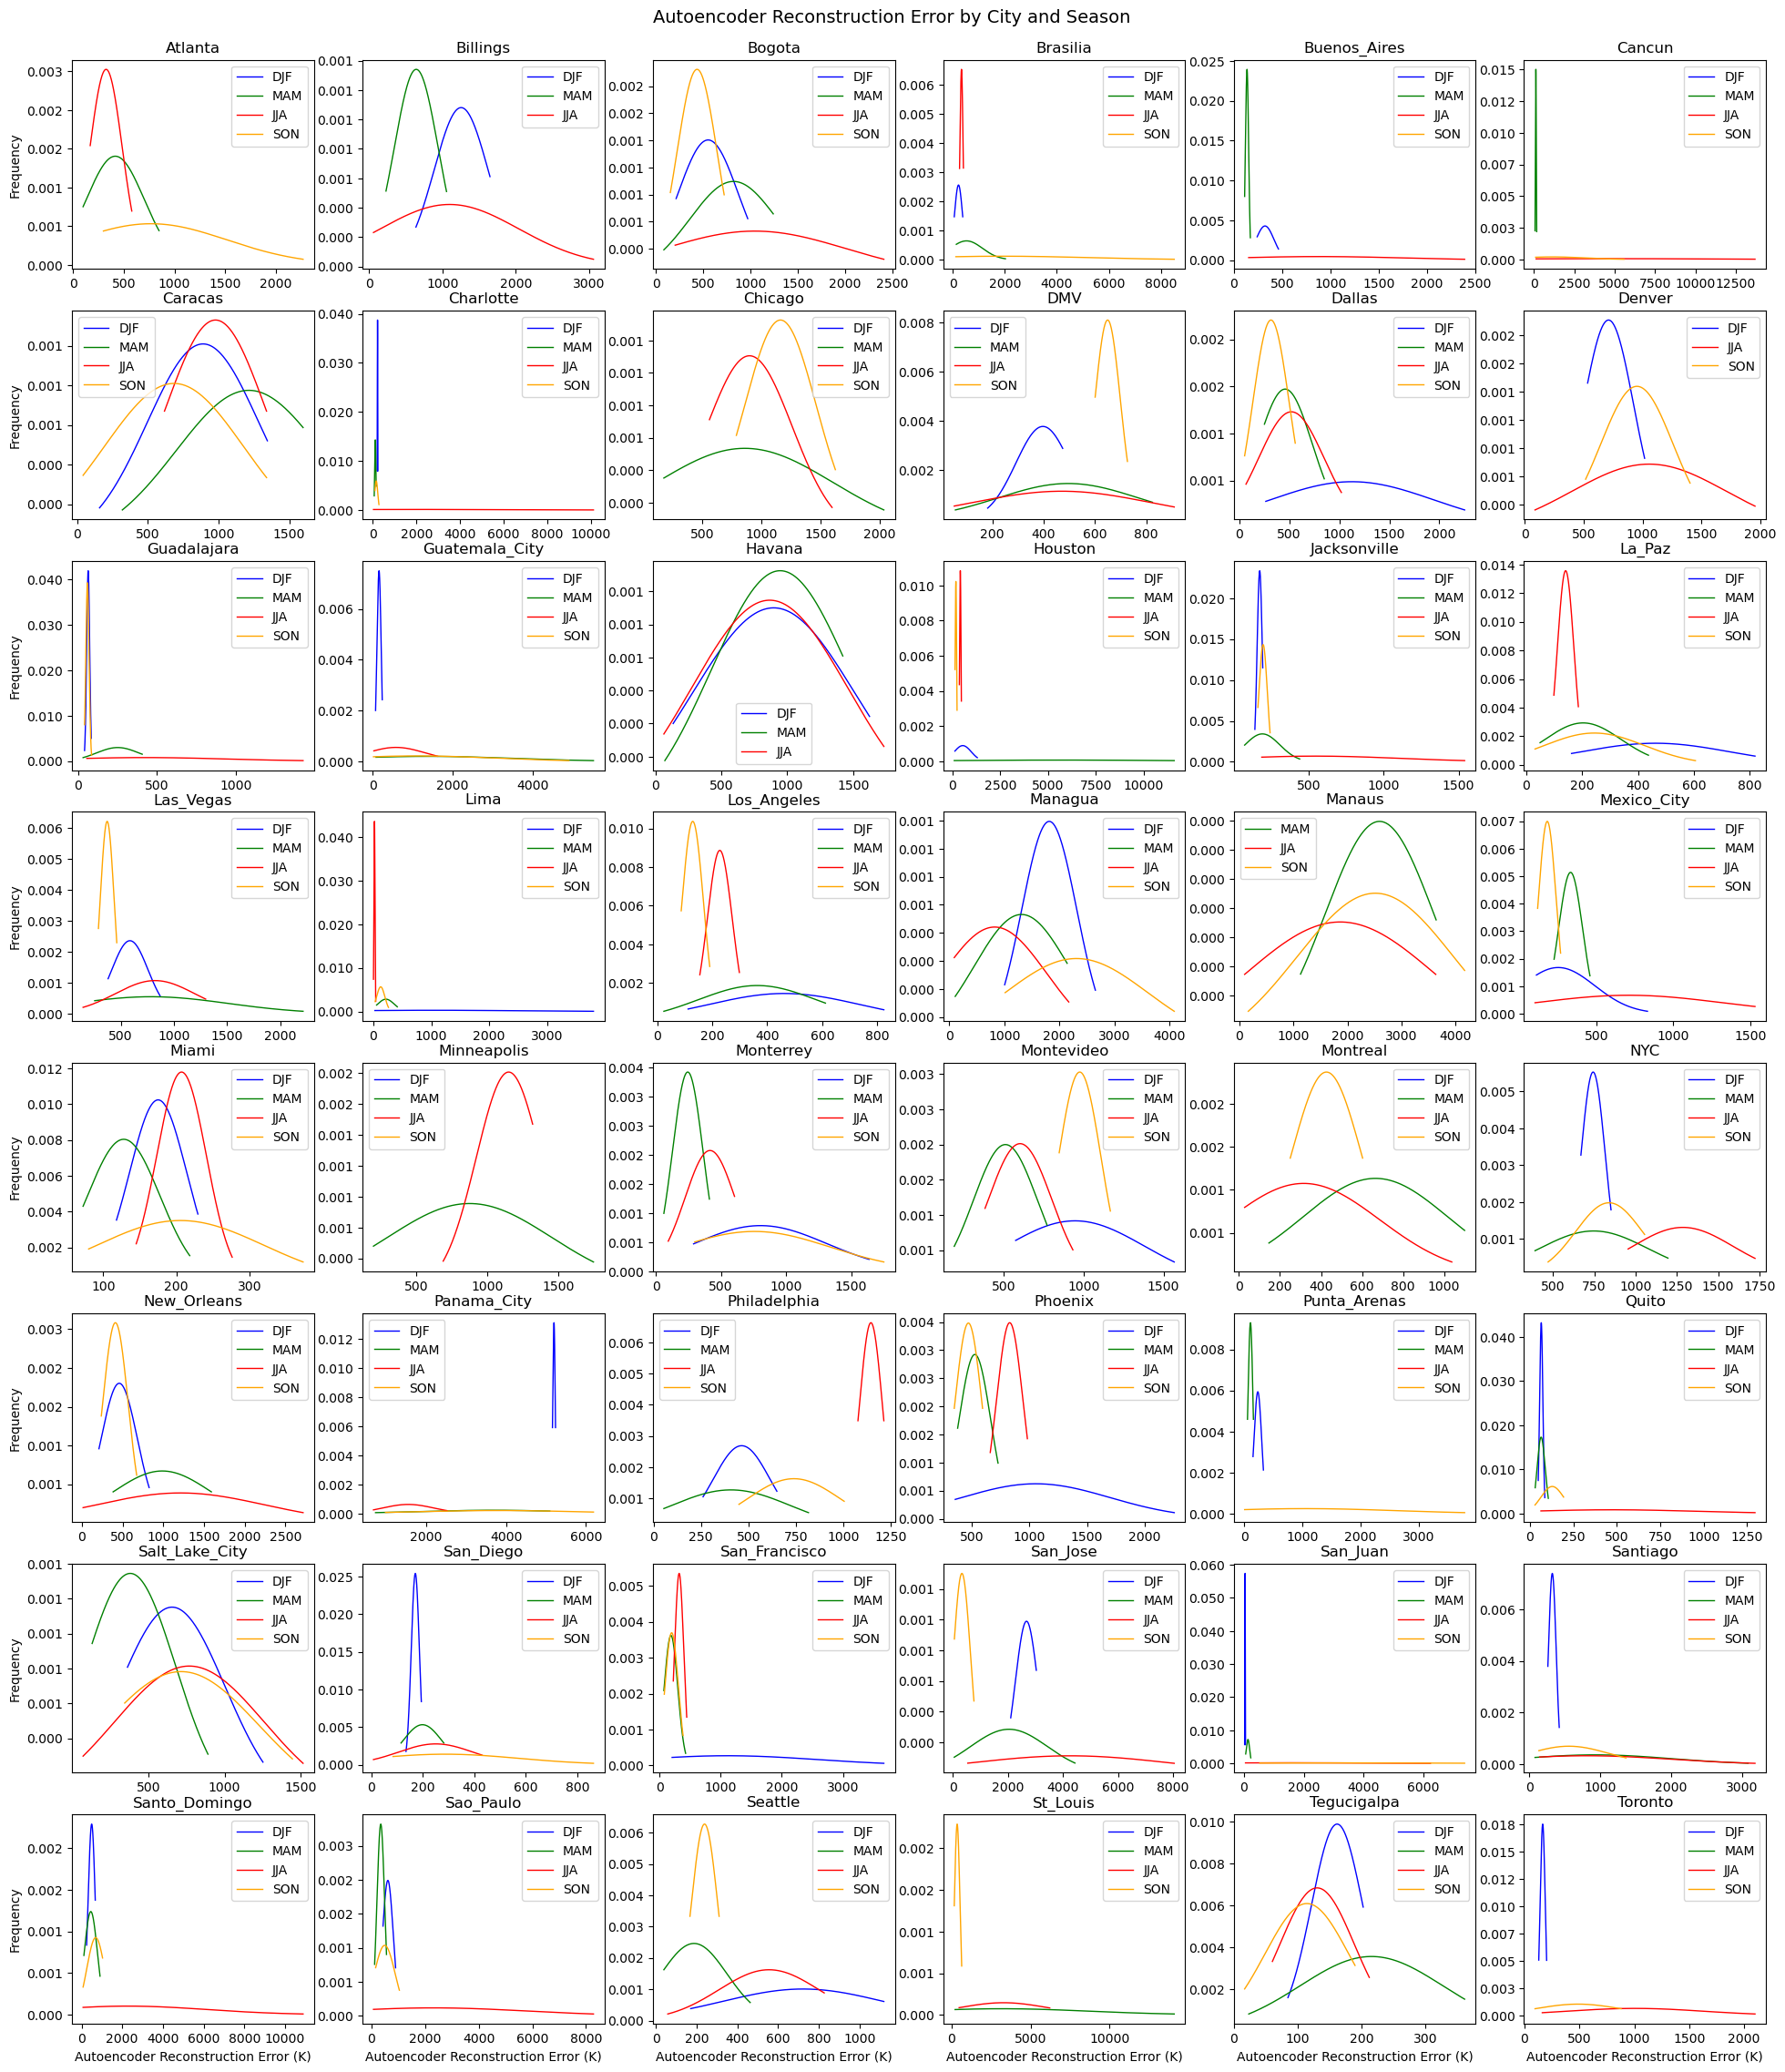

In [55]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]
        analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)
        DJF_errors, MAM_errors, JJA_errors, SON_errors = get_reconstruction_error_seasons(analysis_dataset)
        if len(DJF_errors) > 0:
            DJF_x, DJF_pdf = get_pdf(DJF_errors)
            axs[i,j].plot(DJF_x, DJF_pdf, color='b', linewidth=1, label='DJF')
        if len(MAM_errors) > 0:
            MAM_x, MAM_pdf = get_pdf(MAM_errors)
            axs[i,j].plot(MAM_x, MAM_pdf, color='g', linewidth=1, label='MAM')
        if len(JJA_errors) > 0:
            JJA_x, JJA_pdf = get_pdf(JJA_errors)
            axs[i,j].plot(JJA_x, JJA_pdf, color='r', linewidth=1, label='JJA')
        if len(SON_errors) > 0:
            SON_x, SON_pdf = get_pdf(SON_errors)
            axs[i,j].plot(SON_x, SON_pdf, color='orange', linewidth=1, label='SON')

        axs[i,j].legend()
        axs[i,j].set_title(city)
        #axs[i,j].set_xlim(0, 1500)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i,j].yaxis.set_major_formatter(formatter_y)

        if j == 0:
            axs[i,j].set_ylabel('Frequency')
        if i == 7:
            axs[i,j].set_xlabel('Autoencoder Reconstruction Error (K)')

        plt.suptitle('Autoencoder Reconstruction Error by City and Season', y=0.9, fontsize=14)

In [20]:
def cloud(val):
    try:
        return (str(int(val))[-4] == '1')
    except:
        return False

def shadow(val):
    try:
        return (str(int(val))[-5] == '1')
    except:
        return False

def water(val):
    try:
        return (str(int(val))[-8] == '1')
    except:
        return False

cloud_func = np.vectorize(cloud)
shadow_func = np.vectorize(shadow)
water_func = np.vectorize(water)

In [25]:
ds = xr.open_dataset(analysis_dataset.img_list[0])
mask = ds['Landsat_cloud_mask'].values
cloud_arr = cloud_func(mask)
shadow_arr = shadow_func(mask)
water_arr = water_func(mask)

In [21]:
def get_reconstruction_error_by_feature(city):
    # Make arrays to store loss values
    analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', city)
    cloud_losses = np.zeros(len(analysis_dataset))
    shadow_losses = np.zeros(len(analysis_dataset))
    water_losses = np.zeros(len(analysis_dataset))
    other_losses = np.zeros(len(analysis_dataset))

    # Load model for the city
    save_model = f'/glade/work/jstarfeldt/autoencoder/model_saves/{city}_autoencoder.pth'
    model = HeatAutoencoder()
    model.load_state_dict(torch.load(save_model, weights_only=True))
    
    i = 0
    for i in range(len(analysis_dataset)):
        ds = xr.open_dataset(analysis_dataset.img_list[i])
        mask = ds['Landsat_cloud_mask'].values
        cloud_arr = cloud_func(mask)
        shadow_arr = shadow_func(mask)
        water_arr = water_func(mask)
        other_arr = np.logical_and(np.logical_and(cloud_arr == 0, shadow_arr == 0), water_arr == 0)

        orig, reconstructed = get_reconstructed_data(analysis_dataset[i], model, analysis_dataset.var_mean, analysis_dataset.var_std)
        errors = torch.abs(orig-reconstructed)[0,0]

        other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
        cloud_losses[i] = np.sum(np.where(cloud_arr, errors, 0))/np.sum(cloud_arr)
        shadow_losses[i] = np.sum(np.where(shadow_arr, errors, 0))/np.sum(shadow_arr)
        water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)
    return other_losses, cloud_losses, shadow_losses, water_losses

In [39]:
overall_losses_all_city = []
cloud_losses_all_city = []
shadow_losses_all_city = []
water_losses_all_city = []

for city in cities[42:]:
    print(city)
    overall_losses, cloud_losses, shadow_losses, water_losses = get_reconstruction_error_by_feature(city)
    overall_losses_all_city.append(overall_losses)
    cloud_losses_all_city.append(cloud_losses)
    shadow_losses_all_city.append(shadow_losses)
    water_losses_all_city.append(water_losses)

Santo_Domingo
Sao_Paulo


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:26: RuntimeWarning: invalid value encountered in divide
  other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)


Seattle


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:26: RuntimeWarning: invalid value encountered in divide
  other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)


St_Louis


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:26: RuntimeWarning: invalid value encountered in divide
  other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:28: RuntimeWarning: invalid value encountered in divide
  shadow_losses[i] = np.sum(np.where(shadow_arr, errors, 0))/np.sum(shadow_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:26: RuntimeWarning: invalid value encountered in divide
  other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_ar

Tegucigalpa
Toronto


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:26: RuntimeWarning: invalid value encountered in divide
  other_losses[i] = np.sum(np.where(other_arr, errors, 0))/np.sum(other_arr)
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_11471/449480165.py:29: RuntimeWarning: invalid value encountered in divide
  water_losses[i] = np.sum(np.where(water_arr, errors, 0))/np.sum(water_arr)


In [52]:
with open('/glade/work/jstarfeldt/autoencoder/other_reconstruction_losses_all.pkl', 'wb') as file:
    pickle.dump(overall_losses_all_city, file)
#with open('/glade/work/jstarfeldt/autoencoder/cloud_reconstruction_losses_all.pkl', 'wb') as file:
#    pickle.dump(cloud_losses_all_city, file)
#with open('/glade/work/jstarfeldt/autoencoder/shadow_reconstruction_losses_all.pkl', 'wb') as file:
#    pickle.dump(shadow_losses_all_city, file)
#with open('/glade/work/jstarfeldt/autoencoder/water_reconstruction_losses_all.pkl', 'wb') as file:
#    pickle.dump(water_losses_all_city, file)

In [22]:
with open('/glade/work/jstarfeldt/autoencoder/other_reconstruction_losses_all.pkl', 'rb') as file:
    overall_losses_all_city = pickle.load(file)
with open('/glade/work/jstarfeldt/autoencoder/cloud_reconstruction_losses_all.pkl', 'rb') as file:
    cloud_losses_all_city = pickle.load(file)
with open('/glade/work/jstarfeldt/autoencoder/shadow_reconstruction_losses_all.pkl', 'rb') as file:
    shadow_losses_all_city = pickle.load(file)
with open('/glade/work/jstarfeldt/autoencoder/water_reconstruction_losses_all.pkl', 'rb') as file:
    water_losses_all_city = pickle.load(file)

In [23]:
overall_x, overall_pdf = get_pdf(np.concatenate(overall_losses_all_city))
cloud_x, cloud_pdf = get_pdf(np.concatenate(cloud_losses_all_city))
shadow_x, shadow_pdf = get_pdf(np.concatenate(shadow_losses_all_city))
water_x, water_pdf = get_pdf(np.concatenate(water_losses_all_city))

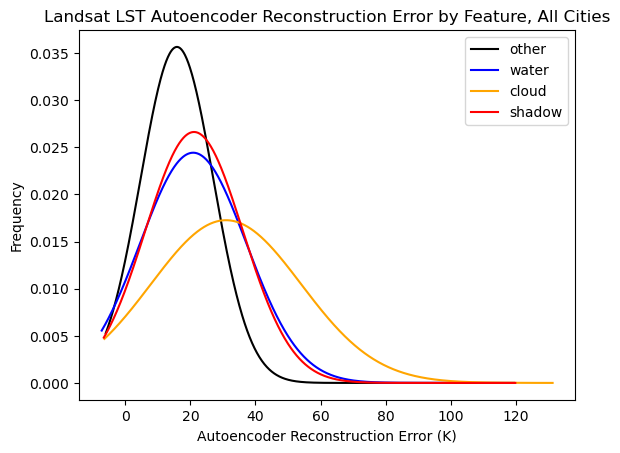

In [24]:
plt.plot(overall_x, overall_pdf, label='other', color='k')
plt.plot(water_x, water_pdf, label='water', color='blue')
plt.plot(cloud_x, cloud_pdf, label='cloud', color='orange')
plt.plot(shadow_x, shadow_pdf, label='shadow', color='red')
plt.title('Landsat LST Autoencoder Reconstruction Error by Feature, All Cities')
plt.xlabel('Autoencoder Reconstruction Error (K)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/glade/work/jstarfeldt/autoencoder/average_feature_reconstruction_error.svg', transparent=True, bbox_inches='tight')

0
1
2
3
4
5
6
7


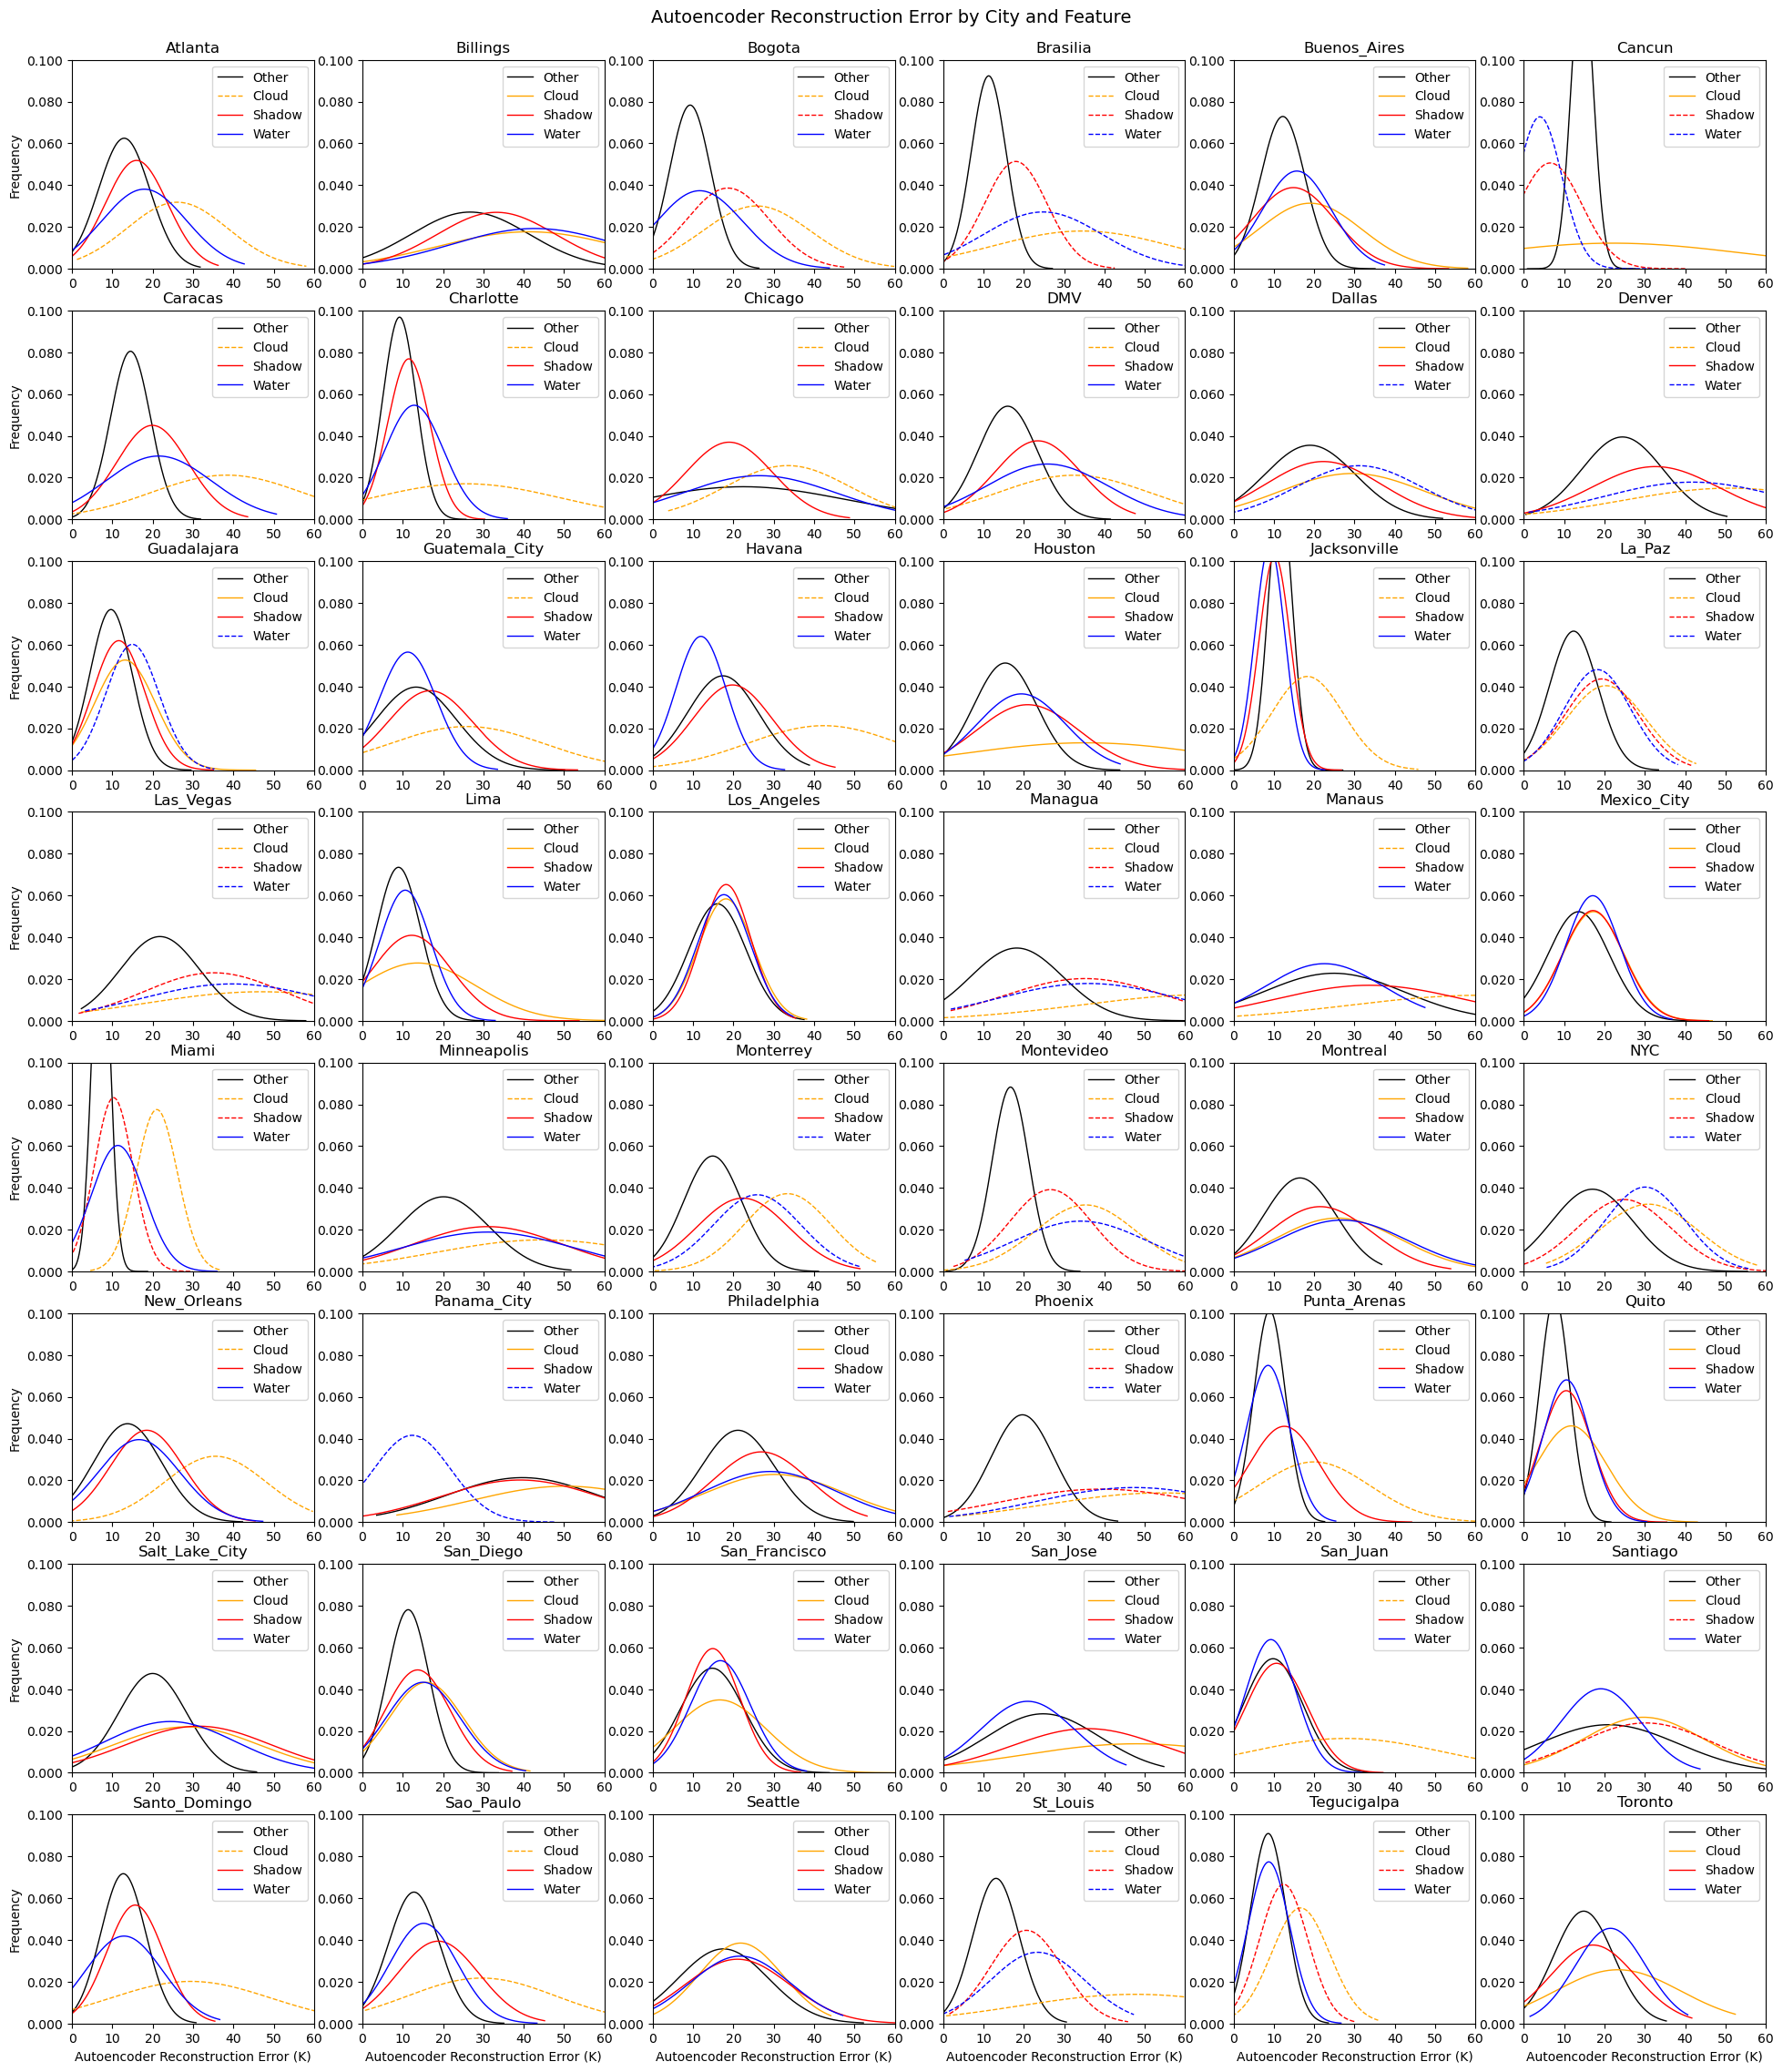

In [25]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]
        overall_losses = overall_losses_all_city[i*6+j]
        overall_x, overall_pdf = get_pdf(overall_losses)
        cloud_losses = cloud_losses_all_city[i*6+j]
        cloud_x, cloud_pdf = get_pdf(cloud_losses)
        shadow_losses = shadow_losses_all_city[i*6+j]
        shadow_x, shadow_pdf = get_pdf(shadow_losses)
        water_losses = water_losses_all_city[i*6+j]
        water_x, water_pdf = get_pdf(water_losses)

        # Run Mann-Whitney tests for difference of distribution for each feature
        cloud_p_value = stats.mannwhitneyu(overall_losses, cloud_losses, nan_policy='omit').pvalue
        shadow_p_value = stats.mannwhitneyu(overall_losses, shadow_losses, nan_policy='omit').pvalue
        water_p_value = stats.mannwhitneyu(overall_losses, water_losses, nan_policy='omit').pvalue

        # Plot PDFs of each feature
        axs[i,j].plot(overall_x, overall_pdf, color='k', linewidth=1, label='Other')
        if cloud_p_value < 0.05:
            axs[i,j].plot(cloud_x, cloud_pdf, color='orange', linewidth=1, label='Cloud', linestyle='dashed')
        else:
            axs[i,j].plot(cloud_x, cloud_pdf, color='orange', linewidth=1, label='Cloud')
        if shadow_p_value < 0.05:
            axs[i,j].plot(shadow_x, shadow_pdf, color='r', linewidth=1, label='Shadow', linestyle='dashed')
        else:
            axs[i,j].plot(shadow_x, shadow_pdf, color='r', linewidth=1, label='Shadow')
        if water_p_value < 0.05:
            axs[i,j].plot(water_x, water_pdf, color='b', linewidth=1, label='Water', linestyle='dashed')
        else:
            axs[i,j].plot(water_x, water_pdf, color='b', linewidth=1, label='Water')
        axs[i,j].legend()
        axs[i,j].set_title(city)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i,j].yaxis.set_major_formatter(formatter_y)
        axs[i,j].set_xlim(left=0, right=60)
        axs[i,j].set_xticks(np.arange(0, 61, 10))
        axs[i,j].set_ylim(bottom=0, top=0.1)
        axs[i,j].set_yticks(np.arange(0, 0.11, 0.02))

        if j == 0:
            axs[i,j].set_ylabel('Frequency')
        if i == 7:
            axs[i,j].set_xlabel('Autoencoder Reconstruction Error (K)')

        plt.suptitle('Autoencoder Reconstruction Error by City and Feature', y=0.9, fontsize=14)
        
fig.savefig('/glade/work/jstarfeldt/autoencoder/Feature_reconstruction_error.svg', transparent=True, bbox_inches='tight')